In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from dsn.util.systems import LowRankRNN
from dsn.train_dsn import train_dsn
from dsn.util.plot_util import assess_constraints, pairplot
import warnings
import scipy
import time
warnings.filterwarnings("ignore")

/Users/sbittner/anaconda/envs/dsn/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)
/Users/sbittner/anaconda/envs/dsn/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# set fixed params
fixed_params = {}

# set behavior
behavior_type = 'struct_chaos'
means = np.array([1.0, 1.0, 0.5]);
variances = np.array([0.25, 0.25, 0.25]);
behavior = {'type':behavior_type, \
            'means':means, \
            'variances':variances}

# set model options
model_opts = {'rank':1, 'input_type':'spont'}

solve_its = 25
solve_eps = 0.5

system = LowRankRNN(fixed_params, behavior, model_opts=model_opts, \
                    solve_its=solve_its, solve_eps=solve_eps)

In [3]:
sample_str = 'grid';

if (sample_str == 'grid'):
    # create test parameter grid
    bound = 4.0
    start = 0.0;
    stop = bound;
    res = 0.5
    eps = .001*res;
    vals = np.arange(start, stop+eps, res);
    num_pts = vals.shape[0];

    total_pts = num_pts**4;
    params = np.zeros((total_pts,4));
    ind = 0;
    for i in range(num_pts):
        g = vals[i];
        for j in range(num_pts):
            Mm = vals[j];
            for k in range(num_pts):
                Mn = vals[k];
                for l in range(num_pts):
                    Sm = vals[l];
                    params[ind, :] = np.array([g, Mm, Mn, Sm])
                    ind += 1;
    
elif (sample_str == 'file'):
    nlayers = 10;
    sigma_init = 1.0;
    c_init = -4;
    rs = 4;
        
    savedir = basedir + system_dir + '/' \
      'V1_circuit_D=8_flow=M_%dP_sigma=%.2f_lr_order=-3_c=%d_rs=%d/' % \
      (nlayers, sigma_init, c_init, rs);
    fname = savedir + 'results.npz';
    alpha = 0.05;
    npzfile = np.load(fname);
    phis = npzfile['phis'];
    T_phis = npzfile['T_phis'];
    n_suff_stat_train = T_phis.shape[2];
    mu = npzfile['mu'];
    k_max = phis.shape[0]-1;
    p_values, AL_final_its = assess_constraints([fname], alpha, k_max, mu, n_suff_stat_train);
    
    AL_final_it = AL_final_its[0];
    print(AL_final_it, phis.shape)
    params = phis[AL_final_it,:,:];
    print(params.shape);
    total_pts = params.shape[0];

else: # random
    total_pts = 10000;
    params = np.zeros((total_pts,8));
    x = np.random.normal(0,1.0,(total_pts,8));
    params = np.log(1+np.exp(x));

In [4]:
num_params = system.D;
K = 1;
Z = tf.placeholder(dtype=tf.float64, shape=(K, None, num_params));

sess = tf.Session()
T_x = system.compute_suff_stats(Z);
_Z = np.expand_dims(params, 0);

In [5]:
nsamps = params.shape[0]

_T_x = sess.run(T_x, {Z:_Z});


In [6]:
for i in range(system.num_suff_stats):
    Txs = _T_x[0,:,i];
    print('i=%d, min=%.4f, max=%.4f' % (i+1, np.min(Txs), np.max(Txs)));

i=1, min=0.0000, max=16.0000
i=2, min=0.0000, max=70.7029
i=3, min=0.0000, max=18.4288
i=4, min=0.0000, max=256.0000
i=5, min=0.0000, max=4998.8992
i=6, min=0.0000, max=339.6213


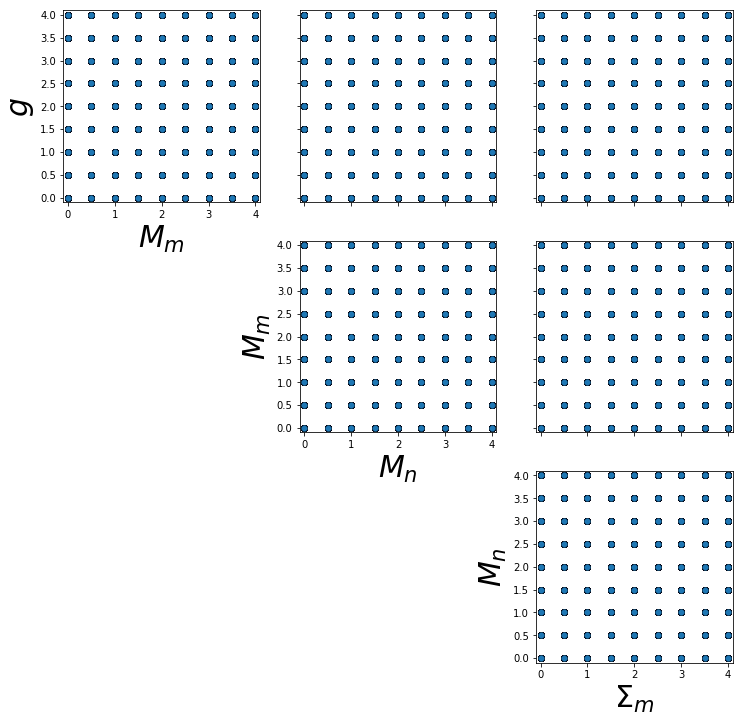

In [7]:
pfname = 'images/LRRNN_grid_search_Z.png'

lims = [-.1, 4.1]
jitter = np.random.normal(0.0, 0.00, _Z.shape)
_Z_plot = (_Z + jitter)[0,:,:]

fig = pairplot(_Z_plot, range(4), system.z_labels, origin=False, \
                       c=None, c_label=None, cmap=None, \
                       xlims=lims, ylims=lims, fontsize=30, \
                       figsize=(12,12), pfname=pfname)



2.659845967142646 3.7681986694553737


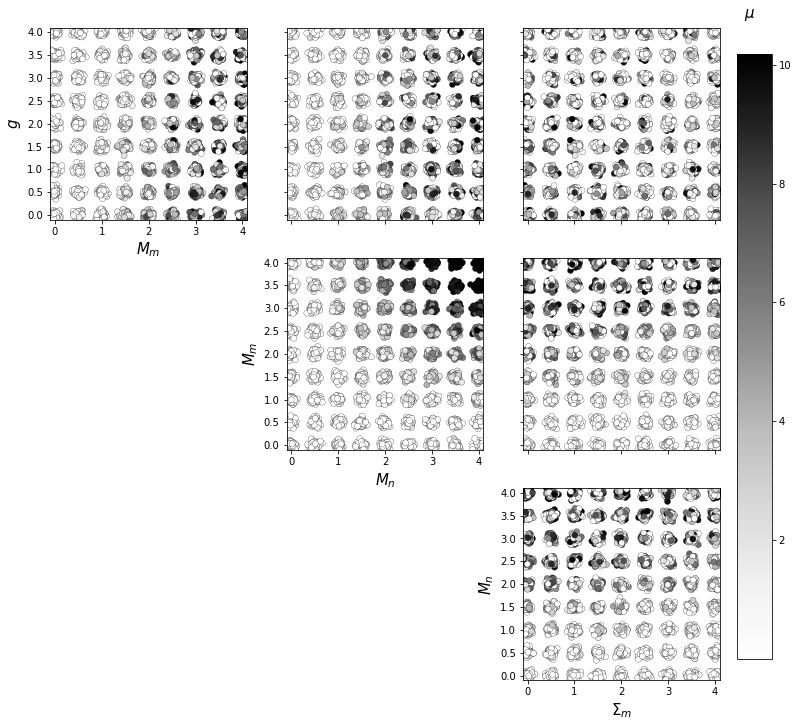

8.392117803255136 14.658898800375672


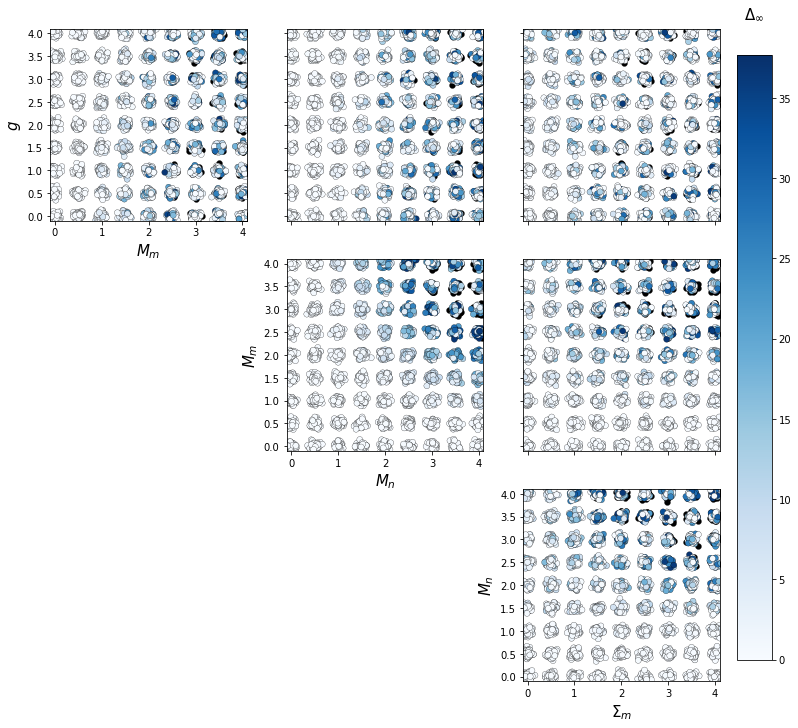

2.8797422119127933 3.1283483284668105


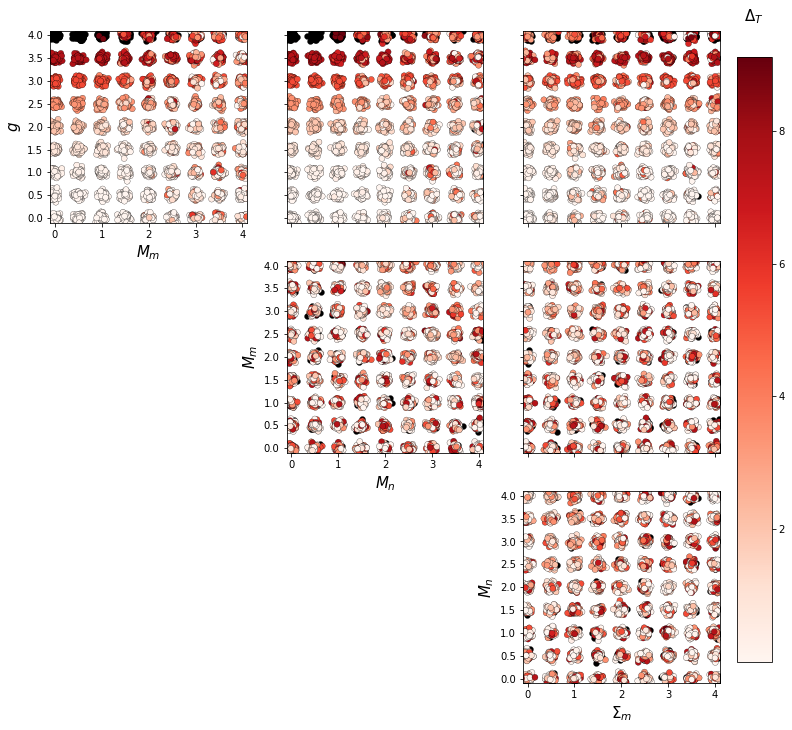

In [8]:
pfname = 'images/Z_S_inc_V_same.png'

cmaps = [plt.cm.get_cmap('Greys'), plt.cm.get_cmap('Blues'), \
         plt.cm.get_cmap('Reds'), plt.cm.get_cmap('Greens')]

lims = [-.1, 4.1]
jitter = np.random.normal(0.0, 0.05, _Z.shape)
_Z_plot = (_Z + jitter)[0,:,:]
for color_ind in range(3):
    fig = pairplot(_Z_plot, range(4), system.z_labels, origin=False, \
                       c=_T_x[0,:,color_ind], c_label=system.T_x_labels[color_ind], cmap=cmaps[color_ind], \
                       xlims=lims, ylims=lims, fontsize=15, \
                       figsize=(12,12), pfname=pfname)

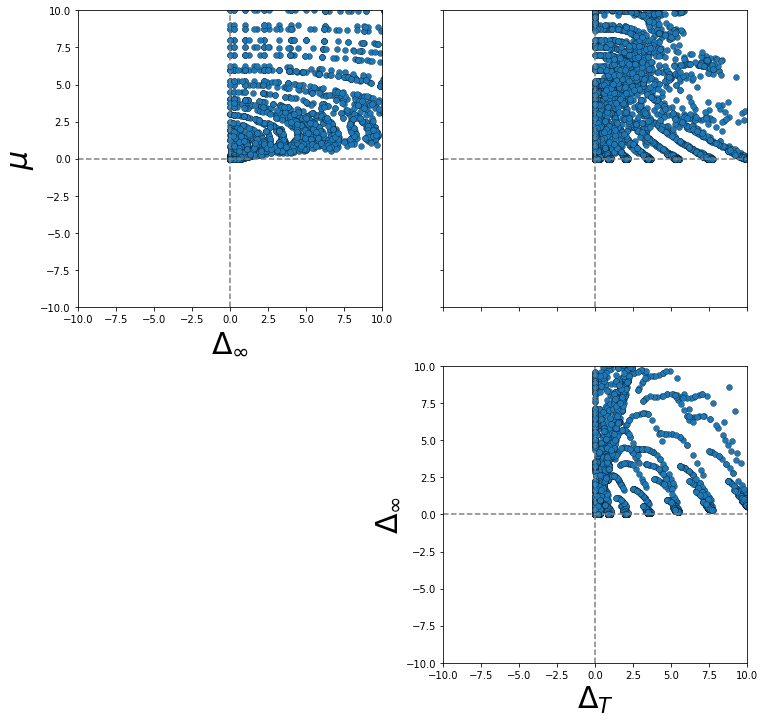

In [9]:
pfname = 'images/LRRNN_grid_search_T_x.png'
axlim = 10
xlims = [-axlim, axlim]
ylims = [-axlim, axlim]

fig = pairplot(_T_x[0], range(3), system.T_x_labels, origin=True, \
                   c=None, c_label=None, cmap=None, \
                   xlims=xlims, ylims=ylims, fontsize=30, \
                   figsize=(12,12), pfname=pfname)



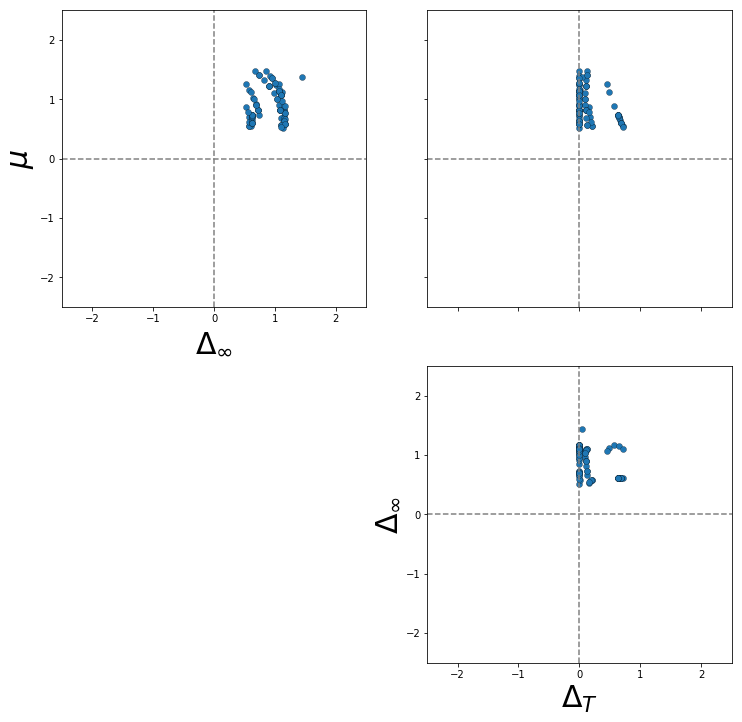

In [11]:
pfname = 'images/LRRNN_grid_search_T_x_thresh.png'

axlim = 2.5
xlims = [-axlim, axlim]
ylims = [-axlim, axlim]

delta_T_inc = np.logical_and(0.0 < _T_x[0,:,2], _T_x[0,:,2] < 1.0);
delta_inf_inc = np.logical_and(0.5 < _T_x[0,:,1], _T_x[0,:,1] < 1.5);
mu_inc = np.logical_and(0.5 < _T_x[0,:,0], _T_x[0,:,0] < 1.5);
delta_inf_inc_delta_T_inc = np.logical_and(delta_T_inc, delta_inf_inc);
inds =  np.logical_and(delta_inf_inc_delta_T_inc, mu_inc);

fig = pairplot(_T_x[0, inds, :], range(3), system.T_x_labels, origin=True, \
                   c=None, c_label=None, cmap=None, \
                   xlims=xlims, ylims=ylims, fontsize=30, \
                   figsize=(12,12), pfname=pfname)

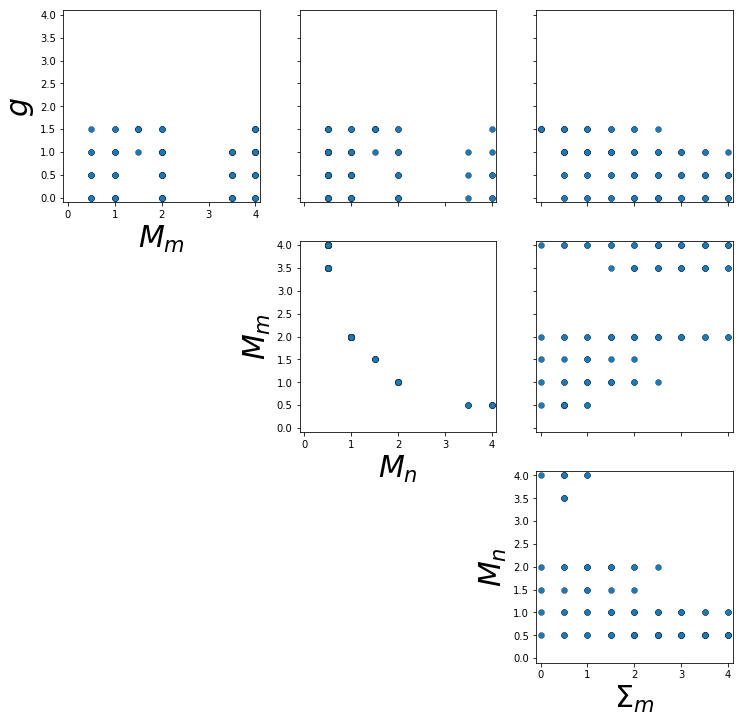

In [12]:
pfname = 'images/LRRNN_grid_search_Z_tresh.png'
_Z_filt = _Z[0,inds, :]

fig = pairplot(_Z_filt, range(4), system.z_labels, origin=False, \
               c=None, c_label=None, cmap=None, \
               xlims=lims, ylims=lims, fontsize=30, \
               figsize=(12,12), pfname=pfname)

85
(1, 6561, 4)
0.9160783645270059 0.27204162404702265


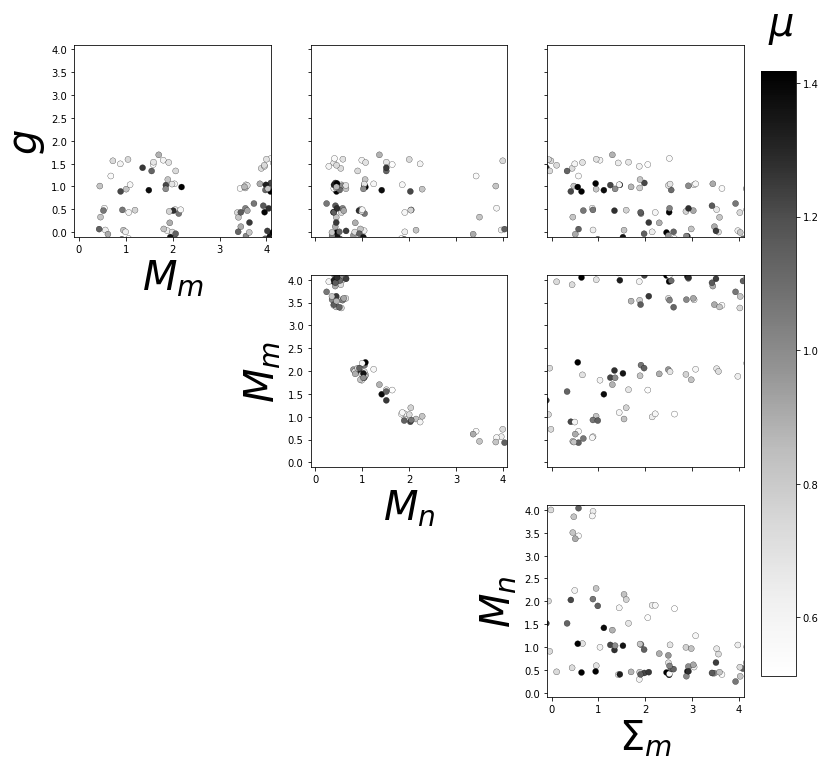

0.9046139795849473 0.2341953991857025


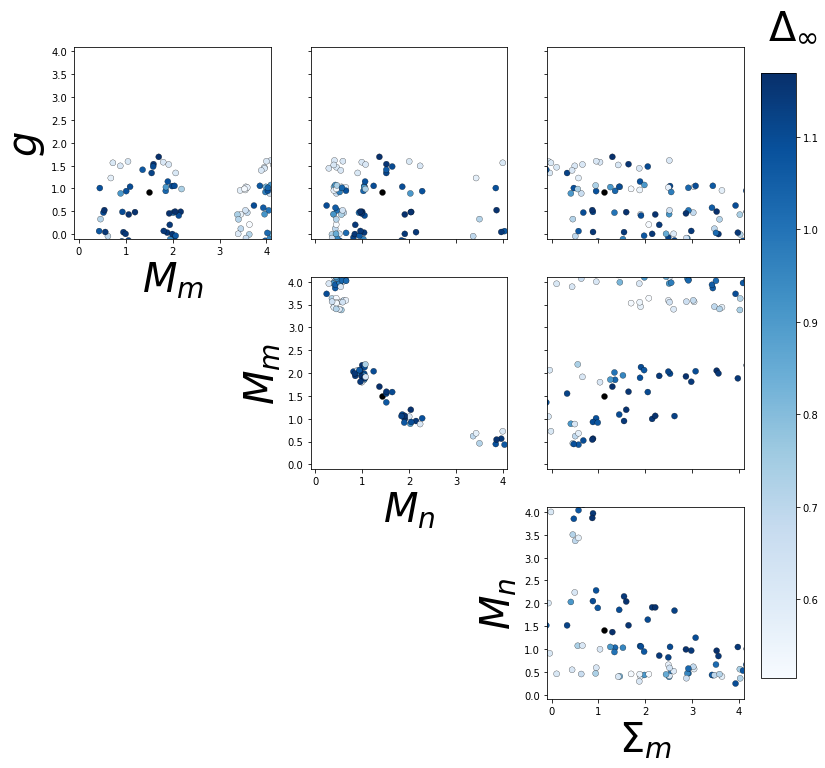

0.16339077951957282 0.24353023746887204


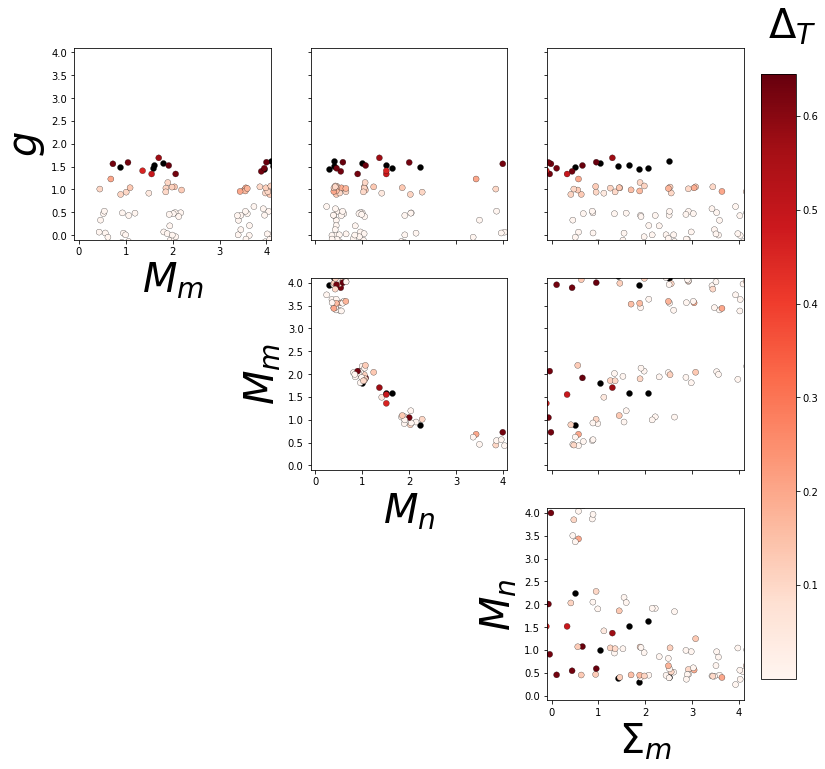

In [13]:
pfname = 'images/Z_S_inc_V_same.png'

mu_inc = np.logical_and(0.5 < _T_x[0,:,0], _T_x[0,:,0] < 1.5);
inds =  np.logical_and(delta_inf_inc_delta_T_inc, mu_inc);

lims = [-.1, 4.1]
print(np.sum(inds))
print(_Z.shape)
_Z_filt = _Z[0,inds, :]
jitter = np.random.normal(0.0, 0.1, _Z_filt.shape)
_Z_filt = _Z_filt + jitter
for color_ind in range(3):
    fig = pairplot(_Z_filt, range(4), system.z_labels, origin=False, \
                       c=_T_x[0,inds,color_ind], c_label=system.T_x_labels[color_ind], cmap=cmaps[color_ind], \
                       xlims=lims, ylims=lims, fontsize=40, \
                       figsize=(12,12), pfname=pfname)